# https://github.com/midnightradio/tsa-tutorial/blob/master/10.%20ARIMA%20and%20Seasonal%20ARIMA.ipynb

## 데이터읽기

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
gangnam1 = pd.read_csv('C:/Users/user/Desktop/NIA/CJ/품목별top10도출/강남/gangnam_series.csv')

In [4]:
gangnam1 = gangnam1['ITEM_QTY']

In [11]:
gangnam1 = gangnam1.loc[0:104]

In [12]:
gangnam1

0       2
1      54
2      55
3       1
4      31
       ..
100     5
101     3
102     4
103    29
104    15
Name: ITEM_QTY, Length: 105, dtype: int64

## 시각화

In [4]:
timeseries = gangnam1['ITEM_QTY']

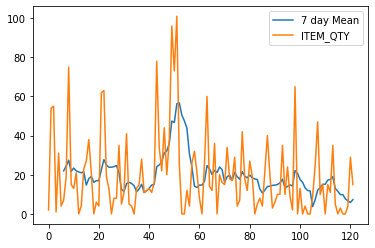

In [5]:
#7일 이동평균 시각화
timeseries.rolling(7).mean().plot(label='7 day Mean')
timeseries.plot()
plt.legend()

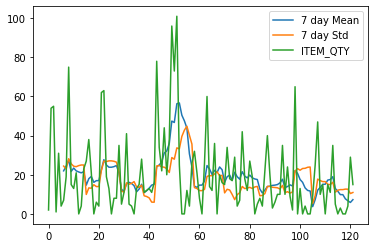

In [6]:
timeseries.rolling(7).mean().plot(label='7 day Mean')
timeseries.rolling(7).std().plot(label='7 day Std')
timeseries.plot()
plt.legend()

## Testing for Stationarity

시계열 데이터의 Stationarity 특성을 시험하기 위해 Augmented Dickey-Fuller unit root test 를 사용합니다.
시계열 데이터에 unit root 가 있어 non-stationary 하다는 귀무가설 H0 를 accept 할지, 또는 이를 reject 하면서 시계열 데이터에 unit root 가 없고 stationary 하다는 대립가설을 채택할지를 실험하는 것입니다.

* p-value 값이 작을 때 (≤ 0.05) 귀무가설을 reject 하고 데이터는 stationary 함
* p-value 값이 클 (> 0.05) 귀무가설을 accept 하고 데이터는 non-stationary 함

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
result = adfuller(gangnam1['ITEM_QTY'])

In [9]:
result

(-3.14678144006598,
 0.023279343130713434,
 5,
 116,
 {'1%': -3.4880216384691867,
  '5%': -2.8867966864160075,
  '10%': -2.5802408234244947},
 945.2726927955116)

In [10]:
# 반복적인 사용을 위해 함수화 합니다.
def adf_check(ts):
    result = adfuller(ts)
    if result[1] <= 0.05:
        print('Stationary {}'.format(result[1]))
    else:
        print('Non-Stationary {}'.format(result[1]))

In [11]:
adf_check(gangnam1['ITEM_QTY']) #정상성이 있는 시계열

Stationary 0.023279343130713434


## Differencing

#### 1차 차분

In [12]:
gangnam1['1st diff'] = gangnam1['ITEM_QTY'] - gangnam1['ITEM_QTY'].shift(1)

In [13]:
gangnam1.head()

,date,ITEM_QTY,1st diff
0,2021-03-01,2,NaN
1,2021-03-02,54,52.0
2,2021-03-03,55,1.0
3,2021-03-04,1,-54.0
4,2021-03-05,31,30.0


In [14]:
adf_check(gangnam1['1st diff'].dropna())

Stationary 5.639680079980449e-18


<AxesSubplot:>

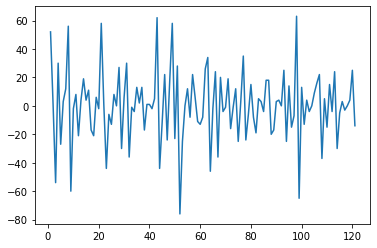

In [15]:
gangnam1['1st diff'].plot()

#### 2차 차분

In [16]:
gangnam1['2nd diff'] = gangnam1['1st diff'] - gangnam1['1st diff'].shift(1) #shift이동함수

In [17]:
adf_check(gangnam1['2nd diff'].dropna()) #dropna 결측치 처리 함수/

Stationary 1.848068100271073e-07


<AxesSubplot:>

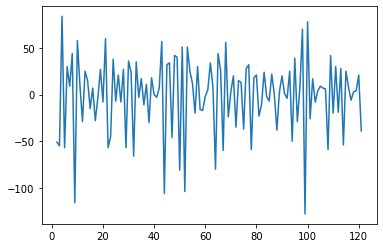

In [18]:
gangnam1['2nd diff'].plot()

#### seasonal 차분

In [19]:
gangnam1['seasonal diff'] = gangnam1['ITEM_QTY'] - gangnam1['ITEM_QTY'].shift(7)

<AxesSubplot:>

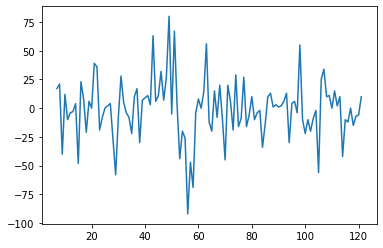

In [20]:
gangnam1['seasonal diff'].plot()

In [21]:
adf_check(gangnam1['seasonal diff'].dropna())

Stationary 3.776993891879313e-08


#### seasonal 1차 차분

In [22]:
gangnam1['seasonal 1st diff'] = gangnam1['1st diff'] - gangnam1['1st diff'].shift(7)

<AxesSubplot:>

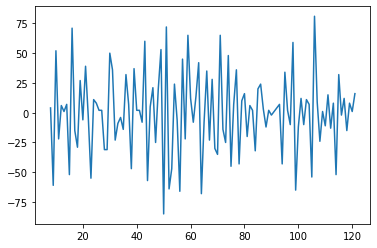

In [23]:
gangnam1['seasonal 1st diff'].plot()

In [24]:
adf_check(gangnam1['seasonal 1st diff'].dropna())

Stationary 1.2759807022793486e-07


ADF #https://rfriend.tistory.com/694

In [25]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [26]:
adf_test(gangnam1['seasonal 1st diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.051256e+00
p-value                        1.275981e-07
#Lags Used                     8.000000e+00
Number of Observations Used    1.050000e+02
Critical Value (1%)           -3.494220e+00
Critical Value (5%)           -2.889485e+00
Critical Value (10%)          -2.581676e+00
dtype: float64


p-value 가 1.275981e-07 이므로 유의수준 5% 하에서
귀무가설(H0: 단위근(unit root)이 존재한다. 즉, 정상 시계열이 아니다)을 기각하고
대립가설 (H1: 단위근이 없다. 즉, 정상 시계열이다.) 을 채택합니다.

## Autocorrelation and Partial Autocorrelation Plots

#### Autocorrelation Interpretation

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

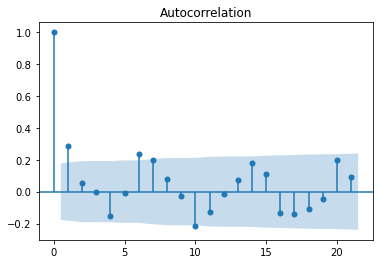

In [28]:
plot_acf(gangnam1['ITEM_QTY'].dropna());

## Partial Autocorrelation

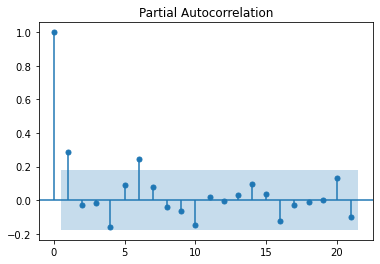

In [29]:
plot_pacf(gangnam1['ITEM_QTY'].dropna(), method='ywm');

# Seasonal ARIMA 모델 사용하기(SARIMA)

In [88]:
model = sm.tsa.statespace.SARIMAX(gangnam1['ITEM_QTY'],
                                 order=(2,0,2),
                                 seasonal_order=(1,1,1,7))

In [37]:
result = model.fit()

In [38]:
print(result.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            ITEM_QTY   No. Observations:                  122
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 7)   Log Likelihood                -504.396
Date:                             Thu, 21 Oct 2021   AIC                           1022.792
Time:                                     09:26:48   BIC                           1042.007
Sample:                                          0   HQIC                          1030.591
                                             - 122                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0237      0.374      0.063      0.950      -0.710       0.758
ar.L2          0.6964      

<AxesSubplot:>

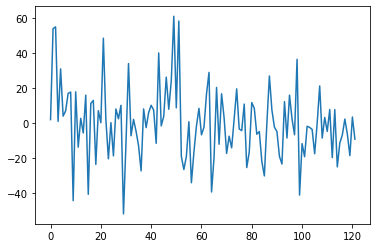

In [39]:
result.resid.plot() #잔차도 그래프

<AxesSubplot:ylabel='Density'>

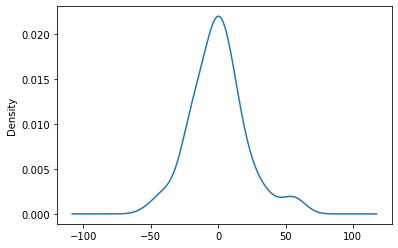

In [40]:
result.resid.plot(kind='kde') #커널밀도추정

# Prediction of Future Values

생성된 모델이 이미 알고 있는 결과 대비 얼마나 좋은 예측 성능을 보여주는지 확인

<AxesSubplot:>

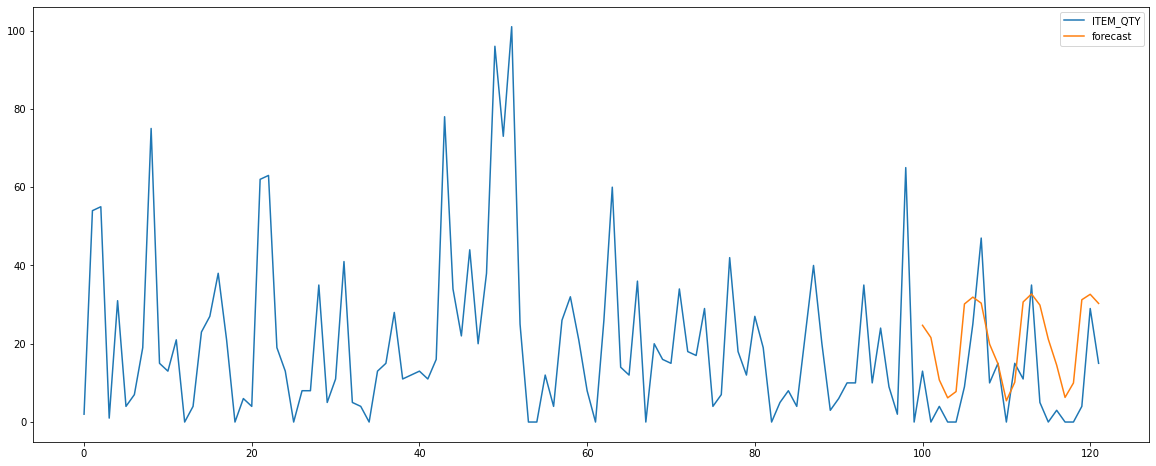

In [51]:
gangnam1['forecast'] = result.predict(start=100, end=150, dynamic=True)
gangnam1[['ITEM_QTY', 'forecast']].plot(figsize=(20,8))

In [57]:
gangnam1

,date,ITEM_QTY,1st diff,2nd diff,seasonal diff,seasonal 1st diff,forecast
0,2021-03-01,2,NaN,NaN,NaN,NaN,NaN
1,2021-03-02,54,52.0,NaN,NaN,NaN,NaN
2,2021-03-03,55,1.0,-51.0,NaN,NaN,NaN
3,2021-03-04,1,-54.0,-55.0,NaN,NaN,NaN
4,2021-03-05,31,30.0,84.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
117,2021-06-26,0,-3.0,-6.0,0.0,12.0,6.291748
118,2021-06-27,0,0.0,3.0,-15.0,-15.0,9.976820
119,2021-06-28,4,4.0,4.0,-7.0,8.0,31.242966
120,2021-06-29,29,25.0,21.0,-6.0,1.0,32.632804


In [71]:
model_forecast(steps=7)

NameError: name 'model_forecast' is not defined

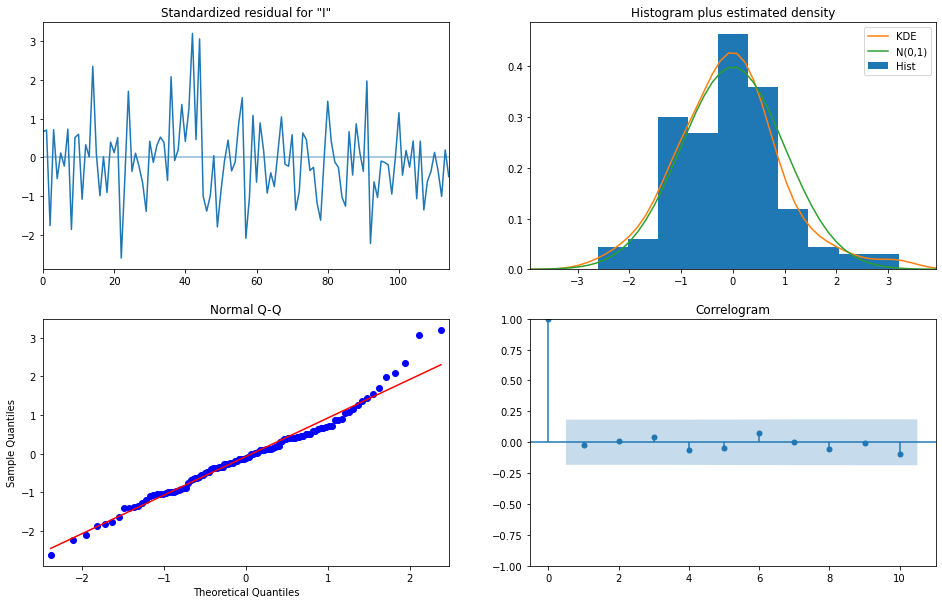

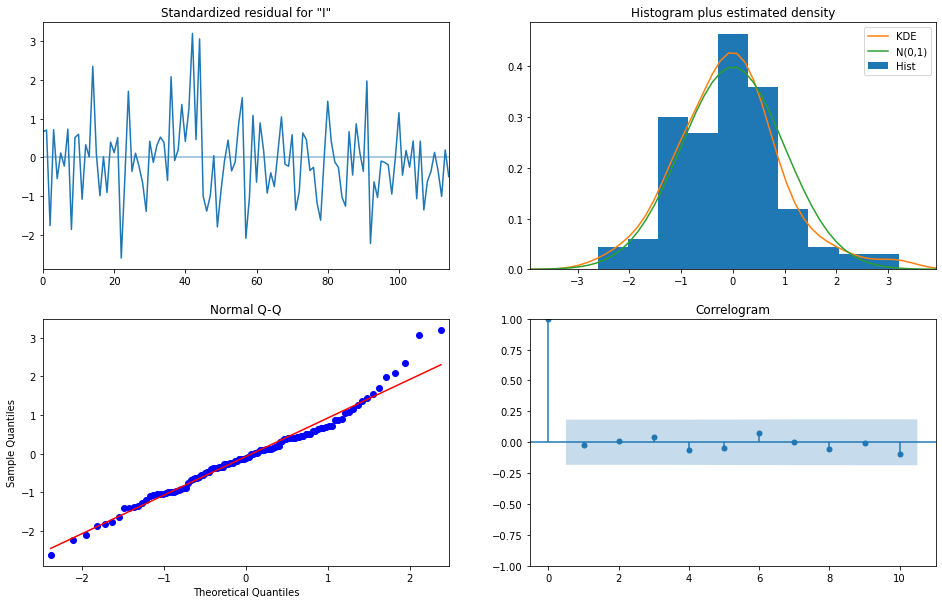

In [73]:
result.plot_diagnostics(figsize=(16,10)) #시각적으로 모델결과 확인

# https://ichi.pro/ko/sigyeyeol-deiteoui-tong-gye-modelling-3-bu-sarimaleul-sayonghayeo-gojeong-sigyeyeol-yecheug-264978318016187

In [2]:
# 필요한 패키지 호출
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# 데이터 불러오기
data = pd.read_csv('C:/Users/user/Desktop/NIA/CJ/품목별top10도출/강남/gangnam_series.csv')
#data = pd.read_csv('C:/Users/user/Desktop/NIA/CJ/품목별top10도출/강서/gangseo_series.csv')
#data = pd.read_csv('C:/Users/user/Desktop/NIA/CJ/품목별top10도출/송파/songpa_series.csv')

In [4]:
#train/test set 분할
train_df = data[0:83]
test_df = data[83:105]

print("Training Set Shape - ", train_df.shape)
print("Testing Set Shape - ", test_df.shape)

Training Set Shape -  (83, 3)
Testing Set Shape -  (22, 3)


In [5]:
# ADF test
from statsmodels.tsa.stattools import adfuller
adfuller(train_df["ITEM_QTY"])
#결과: adf/pvalue/사용된시차/자료수/검정통계량

(-6.7519839599740505,
 2.935298008272892e-09,
 0,
 82,
 {'1%': -3.512738056978279,
  '5%': -2.8974898650628984,
  '10%': -2.585948732897085},
 618.5506903983154)

In [6]:
#SARIMA를 위한 파라미터 자동 분석 후 추천
from pmdarima import auto_arima
stepwise_model = auto_arima(train_df['ITEM_QTY'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=753.841, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=719.054, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=704.015, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.18 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=708.227, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=707.832, Time=0.22 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=723.930, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=700.205, Time=0.13 sec
 ARIMA(0,1,2)(0,1,0)[7]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,2)(1,1,1)[7]             : AIC=702.152, Time=0.20 sec
 ARIMA(0,1,2)(0,1,2)[7]             : AIC=702.200, Time=0.23 sec
 ARIMA

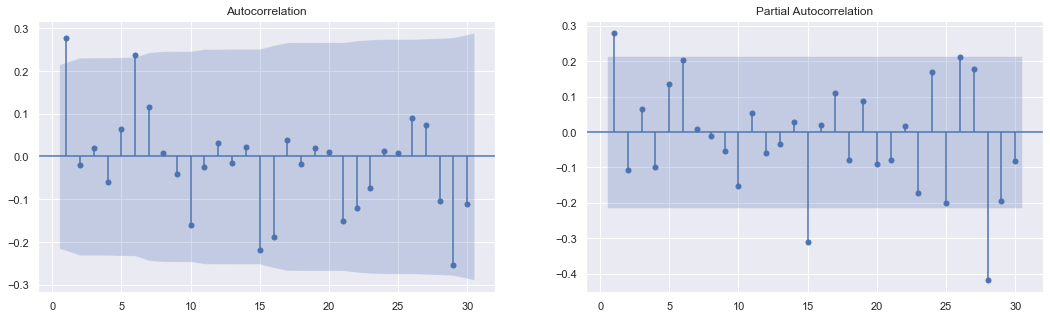

In [7]:
#ARIMA 모형에 대한 매개 변수 선택(p,d,q구하기)
import statsmodels.graphics.tsaplots as sgt
plt.rcParams["figure.figsize"] = 18, 5 #그래프 사이즈
fig, axes = plt.subplots(1, 2)

# ACF, PACF 그래프
sgt.plot_acf(train_df.ITEM_QTY[0:], zero = False, lags = 30, ax = axes[0])
sgt.plot_pacf(train_df.ITEM_QTY[0:], zero = False, lags = 30, ax = axes[1])

# 그래프 보이기
plt.show()

                               SARIMAX Results                                
Dep. Variable:               ITEM_QTY   No. Observations:                   83
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -365.496
Date:                Tue, 26 Oct 2021   AIC                            736.992
Time:                        16:53:01   BIC                            744.212
Sample:                             0   HQIC                           739.891
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6485      4.842     -0.134      0.893     -10.139       8.841
ma.L2         -0.3511      1.780     -0.197      0.844      -3.840       3.138
sigma2       415.1604   2005.903      0.207      0.8

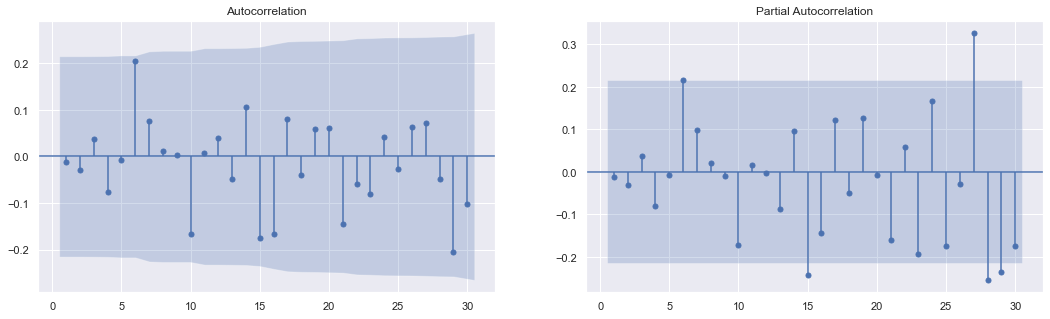

In [8]:
# MODEL FITTING(아리마)
# 테이블 : ARIMA (1, 0, 1) 모델을 피팅 한 후 생성 된 요약 테이블
# 그래프 : ARIMA (2, 0, 2) 모델의 잔차에 대한 ACF 및 PACF 플롯
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 모델 정의
model = SARIMAX(train_df["ITEM_QTY"], order = (0, 1, 2))
# 모델 피팅
model_results = model.fit()
print(model_results.summary())

# 잔차계산
plt.rcParams["figure.figsize"] = 18, 5 
fig, axes = plt.subplots(1, 2)
# ACF, PACF ARIMA 잔차(0, 1, 2)
sgt.plot_acf(model_results.resid[0:], zero = False, lags = 30, ax = axes[0]) #resid 잔차
sgt.plot_pacf(model_results.resid[0:], zero = False, lags = 30, ax = axes[1])
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                            ITEM_QTY   No. Observations:                  637
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood               -2433.034
Date:                             Tue, 26 Oct 2021   AIC                           4874.067
Time:                                     16:53:05   BIC                           4891.844
Sample:                                          0   HQIC                          4880.972
                                             - 637                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8023      0.029    -27.689      0.000      -0.859      -0.746
ma.L2         -0.1727      

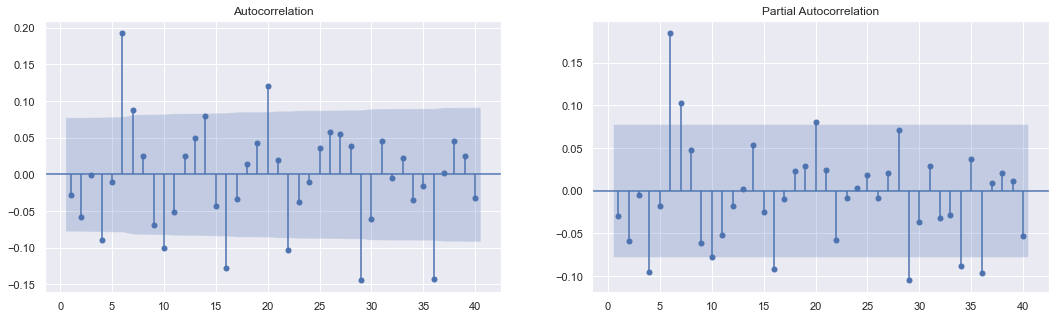

In [9]:
# MODEL FITTING(사리마)
# 패키지 불러오기
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 모델정의
seas_model = SARIMAX(data['ITEM_QTY'], order = (0, 1, 2), seasonal_order = (0, 1, 1, 7))
# 모델피팅
seas_model_results = seas_model.fit()

# 모델 결과 출력
print(seas_model_results.summary())

# 잔차 계산 그래프
plt.rcParams["figure.figsize"] = 18, 5
fig, axes = plt.subplots(1, 2)

# SARIMA 잔차0, 1, 2)(0, 1, 1, 7) ACF, PACF
sgt.plot_acf(seas_model_results.resid[0:], zero = False, lags = 40, ax = axes[0])
sgt.plot_pacf(seas_model_results.resid[0:], zero = False, lags = 40, ax = axes[1])

# 그래프 도출
plt.show()

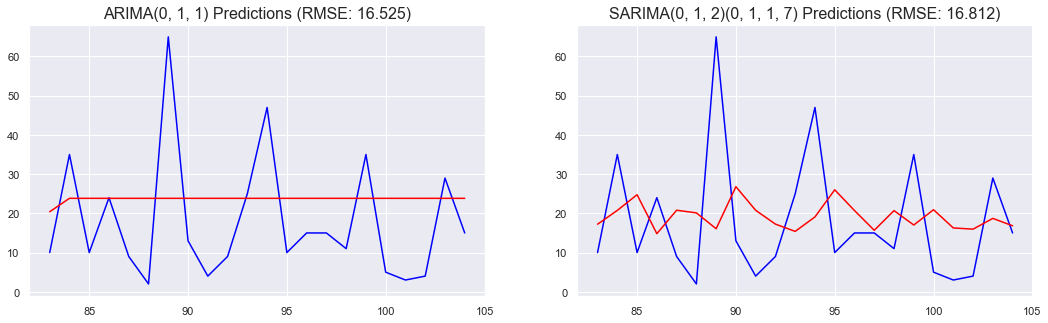

In [10]:
from sklearn.metrics import mean_squared_error

# 예측/정확도 계산
# ARIMA 예측
pred = model_results.predict(start = test_df.index[0], end = test_df.index[-1])
# SARIMA 예측
seas_pred = seas_model_results.predict(start = test_df.index[0], end = test_df.index[-1])

# ARIMA RMSE
arima_rmse = np.sqrt(mean_squared_error(y_true = test_df["ITEM_QTY"].values, y_pred = pred.values))
# SARIMA RMSE
sarima_rmse = np.sqrt(mean_squared_error(y_true = test_df["ITEM_QTY"].values, y_pred = seas_pred.values))


# 예측값과 실제값 그래프 그리기
plt.rcParams["figure.figsize"] = 18, 5 # 그래프 사이즈
fig, ax = plt.subplots(1, 2)

# for ARIMA(1, 0, 1) 실제값과 예측값 그래프
ax[0].plot(test_df["ITEM_QTY"], color = "blue", label = "Actuals")
ax[0].plot(pred, color = "red", label = "ARIMA(0, 1, 2) Predictions")
ax[0].set_title(f"ARIMA(0, 1, 1) Predictions (RMSE: {np.round(arima_rmse, 3)})", size = 16)

# SARIMA(1, 0, 1)(1, 0, 1, 7) 실제값과 예측값 그래프
ax[1].plot(test_df["ITEM_QTY"], color = "blue", label = "Actuals")
ax[1].plot(seas_pred, color = "red", label = "SARIMA(0, 1, 2)(0, 1, 1, 7) Predictions")
ax[1].set_title(f"SARIMA(0, 1, 2)(0, 1, 1, 7) Predictions (RMSE: {np.round(sarima_rmse, 3)})", size = 16)

# Displaying the plots
plt.show()

    lower ITEM_QTY  upper ITEM_QTY  Predictions
83      -19.760800       60.575635    17.228990
84      -18.900291       66.561314    20.753232
85      -18.900294       66.561317    24.752128
86      -18.900296       66.561319    14.812558
87      -18.900299       66.561322    20.793572


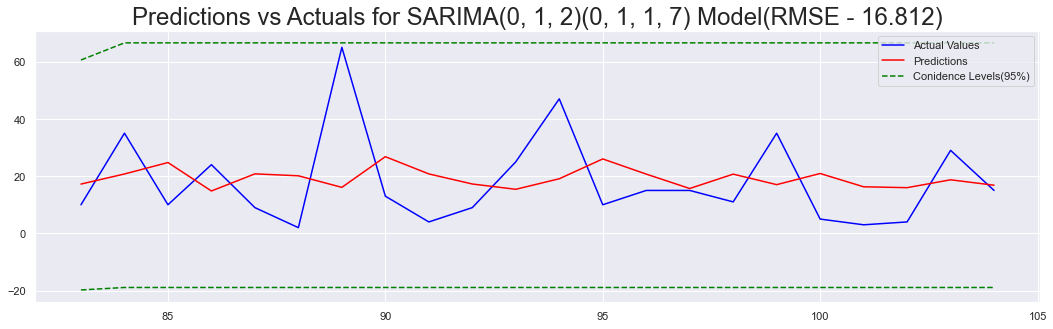

In [11]:
#신뢰구간
# 예측과 신뢰구간
forecasts = model_results.get_forecast(len(test_df.index)) # 예측 객체 생성
forecasts_df = forecasts.conf_int(alpha = 0.05)  # 신뢰구간 95%

# 실제의 예측값
forecasts_df["Predictions"] = seas_model_results.predict (start = test_df.index[0], end = test_df.index[-1])
print(forecasts_df.head()) #orecasts_df
# 예측값 RMSE
sarima_rmse = np.sqrt(mean_squared_error(y_true = test_df["ITEM_QTY"].values, y_pred = forecasts_df["Predictions"].values))
# 예측 신뢰구간 그래프
plt.rcParams["figure.figsize"] = 18, 5

# 테스트셋에서 ITEM_QTY 실제값
plt.plot(test_df["ITEM_QTY"], color = "blue", label = "Actual Values")




# 모델의 예측과 신뢰구간
plt.plot(forecasts_df["Predictions"], color = "red", label = "Predictions")
plt.plot(forecasts_df["upper ITEM_QTY"], color = "green", linestyle = "--", label = "Conidence Levels(95%)")
plt.plot(forecasts_df["lower ITEM_QTY"], color = "green", linestyle = "--")

#그래프 제목 작성 후 도출
plt.title(f"Predictions vs Actuals for SARIMA(0, 1, 2)(0, 1, 1, 7) Model(RMSE - {round(sarima_rmse, 3)})", size = 24)
plt.legend(loc = 'upper right')
plt.show()

In [303]:
forecasts_df1 = forecasts_df[['Predictions']] #Predictions 컬럼만 추출

In [293]:
train_df1 = train_df['ITEM_QTY'] #ITEM_QTY 컬럼만 추출

In [304]:
#모델을 train set에 맞게 조정해 미래 예측
result_seasonal=stepwise_model.fit(train_df1)
print(result_seasonal.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   79
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                -207.779
Date:                           Mon, 25 Oct 2021   AIC                            423.559
Time:                                   17:18:04   BIC                            432.609
Sample:                                        0   HQIC                           427.158
                                            - 79                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0551      0.053      1.041      0.298      -0.049       0.159
ma.L1         -0.8925      0.122     -7.315

In [305]:
pred_seasonal = result_seasonal.predict(n_periods=7) # test개수만큼 예측
print(pred_seasonal)

[ 5.22764741  4.91021076  7.98307667  5.53353138 10.98617912  5.37603361
  4.54870578]


In [ ]:
import math #올림을 도와주는 패키지
list=[]
sresult = 0

# 7일까지 판매갯수 합을 sresult에 저장
for i in range(0,len(pred_seasonal)):
    sresult = sresult + math.ceil(pred_seasonal[i])

# 7일까지 예측한 정수값을 올림 처리
for i in range(0,len(pred_seasonal)):
    list.append(math.ceil(pred_seasonal[i]))

list

In [ ]:
sresult

=> train set을 test set으로 검증해보고 train set을 가지고 미래 예측을 했음

# 정규화 SARIMA

#### 정규화

In [163]:
# Importing Standard Packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [164]:
# Importing Dataset
data = pd.read_csv('C:/Users/user/Desktop/NIA/CJ/품목별top10도출/강남/gangnam_series.csv')

In [166]:
#train/test set 분할
train_df = data[0:83]
test_df = data[83:105]

print("Training Set Shape - ", train_df.shape)
print("Testing Set Shape - ", test_df.shape)

Training Set Shape -  (83, 3)
Testing Set Shape -  (22, 3)


In [167]:
train_df = data['ITEM_QTY']
test_df = data['ITEM_QTY']

In [168]:
train_df = pd.DataFrame(train_df)
test_df = pd.DataFrame(test_df)

In [169]:
train_df['ITEM_QTY'] = pd.to_datetime(train_df['ITEM_QTY'])

In [170]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

train_df = sc.fit_transform(train_df)
test_df = sc.transform(test_df)

In [171]:
# ADF test
from statsmodels.tsa.stattools import adfuller
adfuller(train_df)

(-8.0406533372843,
 1.850954720613451e-12,
 0,
 105,
 {'1%': -3.4942202045135513,
  '5%': -2.889485291005291,
  '10%': -2.5816762131519275},
 -39.306714788381015)

In [172]:
from pmdarima import auto_arima
stepwise_model = auto_arima(train_df, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=77.523, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=32.032, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=0.721, Time=0.07 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=12.890, Time=0.04 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=33.863, Time=0.07 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=-1.652, Time=0.11 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=0.160, Time=0.16 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,1,1)[7]

AttributeError: 'DataFrame' object has no attribute 'ITEM_QTY'

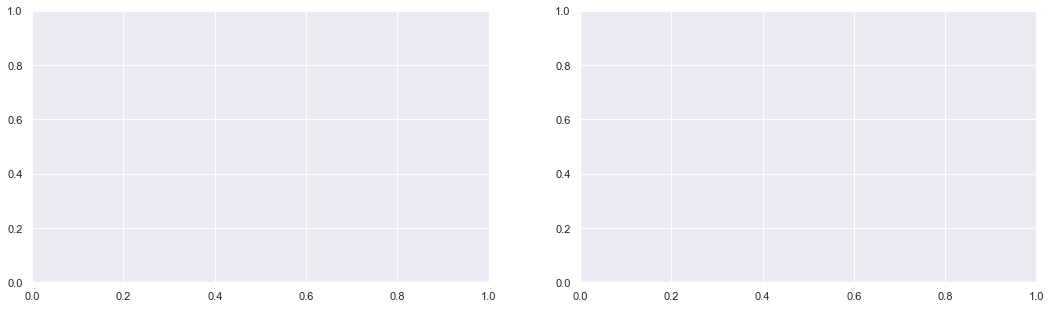

In [181]:
#ARIMA 모형에 대한 매개 변수 선택(p,d,q구하기)
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 18, 5 #plot size

# Defining Subplots
fig, axes = plt.subplots(1, 2)

# Plotting ACF and PACF
sgt.plot_acf(train_df.ITEM_QTY[0:], zero = False, lags = 40, ax = axes[0])
sgt.plot_pacf(train_df.ITEM_QTY[0:], zero = False, lags = 40, ax = axes[1])

# Display the Plot
plt.show()

                               SARIMAX Results                                
Dep. Variable:                      0   No. Observations:                  106
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  19.314
Date:                Fri, 22 Oct 2021   AIC                            -32.628
Time:                        15:40:06   BIC                            -24.666
Sample:                             0   HQIC                           -29.402
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7026      0.116     -6.053      0.000      -0.930      -0.475
ma.L2         -0.2873      0.114     -2.517      0.012      -0.511      -0.064
sigma2         0.0392      0.005      8.148      0.0

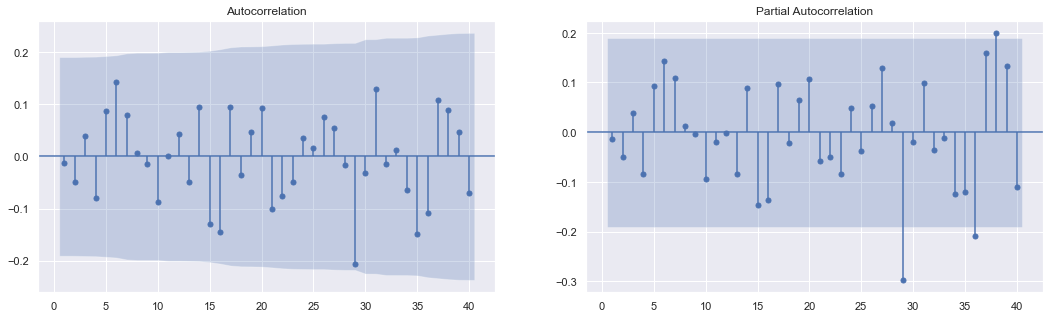

In [182]:
# MODEL FITTING(아리마)
# 테이블 : ARIMA (1, 0, 1) 모델을 피팅 한 후 생성 된 요약 테이블
# 그래프 : ARIMA (2, 0, 2) 모델의 잔차에 대한 ACF 및 PACF 플롯

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining the Model
model = SARIMAX(train_df, order = (0, 1, 2))
# Fitting the Model
model_results = model.fit()

print(model_results.summary())

# EVALUATING RESIDUALS
# Defining the figure size
plt.rcParams["figure.figsize"] = 18, 5
# Defining the subplots 
fig, axes = plt.subplots(1, 2)
# ACF and PACF for residuals of ARIMA(0, 1, 2)
sgt.plot_acf(model_results.resid[0:], zero = False, lags = 40, ax = axes[0]) #resid 잔차
sgt.plot_pacf(model_results.resid[0:], zero = False, lags = 40, ax = axes[1])
# Displaying the plots
plt.show()

In [183]:
import statsmodels.graphics.tsaplots as sgt

                                      SARIMAX Results                                      
Dep. Variable:                            ITEM_QTY   No. Observations:                  106
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 7)   Log Likelihood                -445.715
Date:                             Fri, 22 Oct 2021   AIC                            899.430
Time:                                     15:40:07   BIC                            909.769
Sample:                                          0   HQIC                           903.612
                                             - 106                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6619      0.114     -5.818      0.000      -0.885      -0.439
ma.L2         -0.3014      

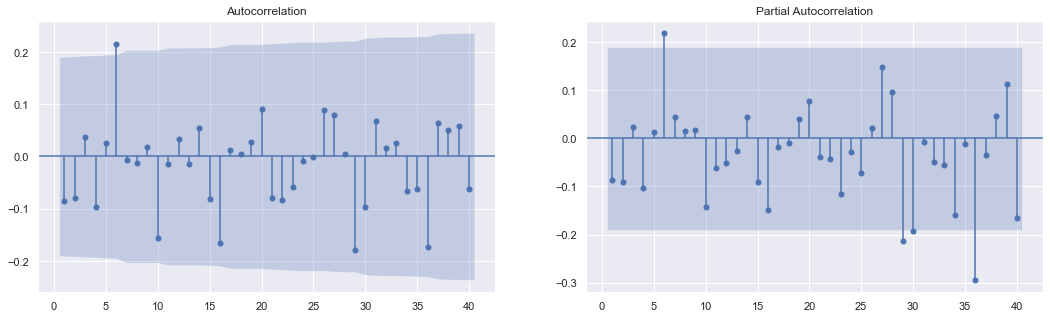

In [184]:
# MODEL FITTING(사리마)
# Importing Required Package
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Defining the Model
seas_model = SARIMAX(data['ITEM_QTY'], order = (0, 1, 2), seasonal_order = (0, 1, 1, 7))
# Fitting the Model
seas_model_results = seas_model.fit()

# Printing the model summary
print(seas_model_results.summary())

# EVALUATING RESIDUALS
# Defining the figure size
plt.rcParams["figure.figsize"] = 18, 5

# Defining the subplots 
fig, axes = plt.subplots(1, 2)

# ACF and PACF for residuals of SARIMA(0, 1, 2)(0, 1, 1, 7)
sgt.plot_acf(seas_model_results.resid[0:], zero = False, lags = 40, ax = axes[0])
sgt.plot_pacf(seas_model_results.resid[0:], zero = False, lags = 40, ax = axes[1])

# Displaying the plots
plt.show()

In [185]:
test_df = pd.DataFrame(test_df)
train_df = pd.DataFrame(train_df)

In [186]:
test_df.columns = ['ITEM_QTY']
train_df.columns = ['ITEM_QTY']

In [187]:
train_df

,ITEM_QTY
0,0.01
1,0.53
2,0.54
3,0.00
4,0.30
...,...
101,0.02
102,0.03
103,0.28
104,0.14


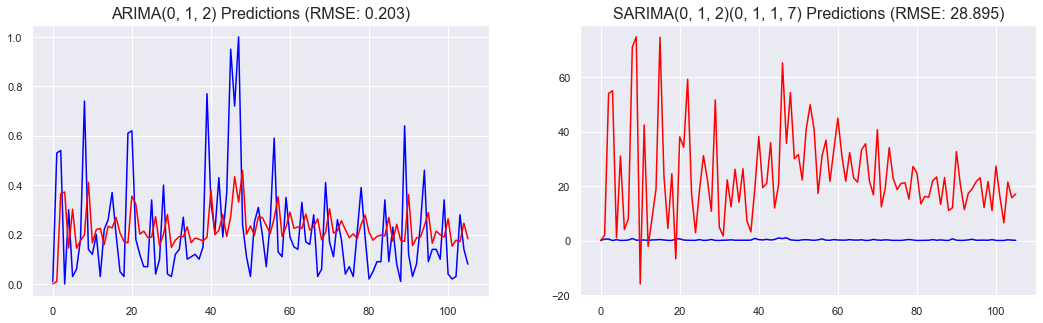

In [188]:
# Importing Required Packages
from sklearn.metrics import mean_squared_error

# GENERATING FORECASTS AND CALCULATING ACCURACY
# Forecasts of ARIMA model
pred = model_results.predict(start = test_df.index[0], end = test_df.index[-1])
# Forecasts of SARIMA model
seas_pred = seas_model_results.predict(start = test_df.index[0], end = test_df.index[-1])

# RMSE of ARIMA model
arima_rmse = np.sqrt(mean_squared_error(y_true = test_df.values, y_pred = pred.values))
# RMSE of SARIMA model
sarima_rmse = np.sqrt(mean_squared_error(y_true = test_df.values, y_pred = seas_pred.values))


# FORECAST vs ACTUALS PLOT
# Setting the size of the figure
plt.rcParams["figure.figsize"] = 18, 5

# Defining the subplots
fig, ax = plt.subplots(1, 2)

# Actuals vs Predictions for ARIMA(1, 0, 1)
ax[0].plot(test_df, color = "blue", label = "Actuals")
ax[0].plot(pred, color = "red", label = "ARIMA(0, 1, 2) Predictions")
ax[0].set_title(f"ARIMA(0, 1, 2) Predictions (RMSE: {np.round(arima_rmse, 3)})", size = 16)

# Actuals vs Predictions for SARIMA(1, 0, 1)(1, 0, 1, 7)
ax[1].plot(test_df, color = "blue", label = "Actuals")
ax[1].plot(seas_pred, color = "red", label = "SARIMA(0, 1, 2)(0, 1, 1, 7) Predictions")
ax[1].set_title(f"SARIMA(0, 1, 2)(0, 1, 1, 7) Predictions (RMSE: {np.round(sarima_rmse, 3)})", size = 16)

# Displaying the plots
plt.show()